In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
from matplotlib.gridspec import GridSpec

from mtj.calc_Heff import calc_Heff
from mtj.calc_Hth import compute_thermal_field
from mtj.init import init_m
from mtj.llg_heun import LLG_Heun
from mtj.constants import VACUUM_PERMEABILITY

### Demonstration of Magnetization Computation

This notebook utilize some core components of our mtj Python library to compute the magnetization of a magnetic sample. In this demonstration, we perform the simulations on a thin film of soft magnetic material (Permalloy), with $M_S\approx1 \space \text{T}$, and a demagnetization tensor with $N_{xx}=N_{yy} = 0$ and $N_{zz}=1$.

**Physical Constants Used**

| Constant | Symbol | Value | Unit | Description |
|----------|--------|-------|------|-------------|
| Vacuum permeability | $\mu_0$ | 1.25663706127e-6 | H/m (T·m/A) | Permeability of free space |
| Saturation magnetization (Permalloy) | $M_S$ | $\approx 1$ | T | Typical for Permalloy |
| Magnetocrystalline anisotropy constant | $K_u$ | $5 \cdot 10^5$ | J/m³ | Example value for perpendicular anisotropy |
| Temperature | $T$ | 300 | K | Room temperature |
| Volume (examples) | $V$ | $18$, $0.5$, $0.001$ | nm³ | Magnetic sample volume |
| Time step | $\Delta t$ | $10^{-13}$ to $10^{-10}$ | s | Simulation time step |
| Damping factor | $\alpha$ | 0.5 | (unitless) | Gilbert damping parameter |

In [2]:
def calculate_magnetization(
    m0: npt.NDArray[
        np.float64
    ],  # Initial magnetization (is normalized before simulation)
    H_app: npt.NDArray[np.float64],
    Tn=1e-10,  # (s)
    dt=1e-13,  # time step (s)
    alpha=0.5,  # Damping factor (arbitrarily chosen in this demo)
    K_u=0,  # Crystal anisotropy constant, default: 0
    M_s=1 / VACUUM_PERMEABILITY,  # Default: NiFe permalloy Ms (A/m)
    u_k=np.zeros(3, dtype=np.float64),  # Not used when K_0 = 0
    N=np.array([[0, 0, 0], [0, 0, 0], [0, 0, 1]]),  # Default: "infinite" thin film
    T=0,  # Temperature (K) - H_th diabled if 0
    V=2e-9 * 3e-9**2,  # Volume
):
    time_series = np.arange(0, Tn, dt)
    m = init_m(m0, len(time_series))

    # Default:  zero thermal field
    H_th = np.zeros(3, dtype=np.float64)

    for i, t in enumerate(time_series[:-1]):
        # Calculate the effective field
        H_eff = calc_Heff(
            m[i],
            K_u,
            M_s,
            u_k,
            np.zeros(3, dtype=np.float64),  # No STT
            0,  # No STT
            0,  # No STT
            V=0,  # No STT
            H_app=H_app,
            N=N,
            stt_enable=False,  # No STT
        )

        # Compute the thermal field if applicable
        if T > 0:
            H_th = compute_thermal_field(alpha, T, M_s, V, dt)

        # Calculate the magnetization for the next time step
        m[i + 1] = LLG_Heun(m[i], H_eff, H_th, dt, alpha)

    return m, time_series

In [3]:
timeFormatter = EngFormatter(unit="s")

We start without thermal fluctuations or STT, finding the equilibrium state when we set $K_u=0$ for a couple of different initial magnetizations. We observe that the equilibrium state is when the magnetization lies in the xy-plane.

/var/folders/6g/lh1pblvx51zgy2yzn03xbj880000gn/T/ipykernel_76624/3517460918.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


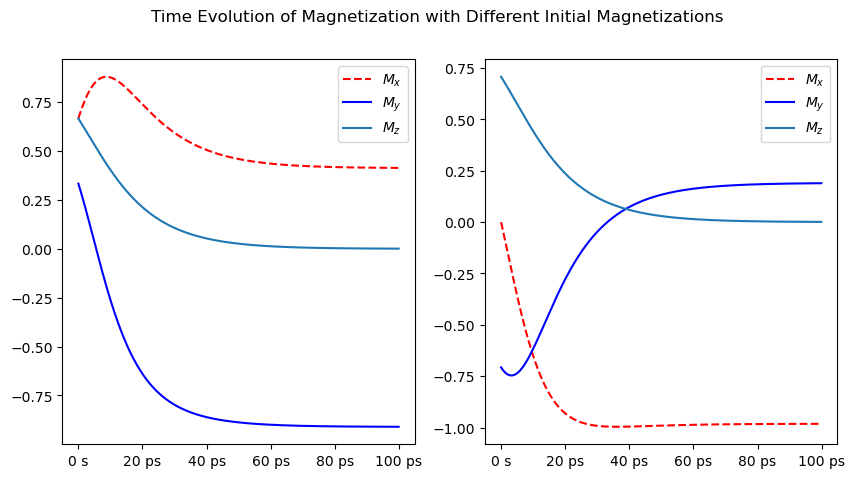

In [4]:
# equilibrium state in zero applied field
m, t = calculate_magnetization(m0=np.array([1, 0.5, 1]), H_app=np.zeros(3))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(t, m[:, 0], "r--", label=r"$M_x$")
ax[0].plot(t, m[:, 1], "b", label=r"$M_y$")
ax[0].plot(t, m[:, 2], label=r"$M_z$")

ax[0].xaxis.set_major_formatter(timeFormatter)
ax[0].legend()

m, t = calculate_magnetization(m0=np.array([0, -1, 1]), H_app=np.zeros(3))

ax[1].plot(t, m[:, 0], "r--", label=r"$M_x$")
ax[1].plot(t, m[:, 1], "b", label=r"$M_y$")
ax[1].plot(t, m[:, 2], label=r"$M_z$")

ax[1].xaxis.set_major_formatter(timeFormatter)
ax[1].legend()
fig.suptitle("Time Evolution of Magnetization with Different Initial Magnetizations")

fig.show()

We apply an external field $H_{app}=10^5 \text{ A/m}$ and $H_{app}=10^6 \text{ A/m}$

/var/folders/6g/lh1pblvx51zgy2yzn03xbj880000gn/T/ipykernel_76624/3967367134.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


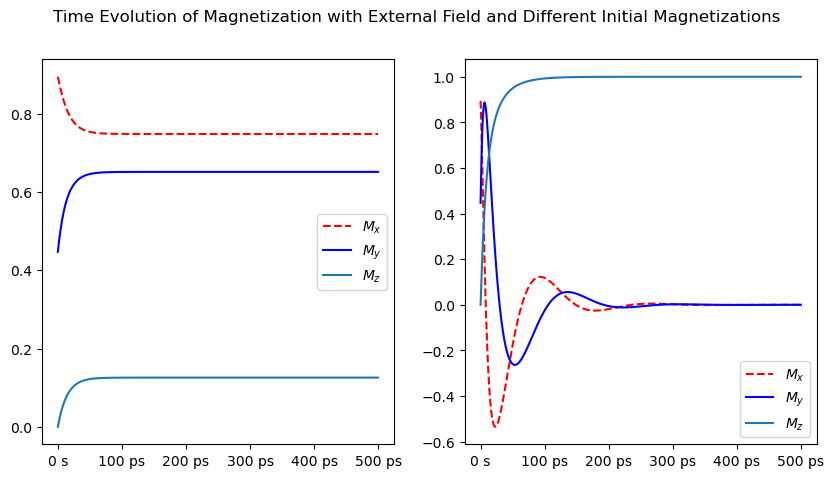

In [5]:
# equilibrium state with applied field
m, t = calculate_magnetization(Tn=5e-10, m0=np.array([1, 0.5, 0]), H_app=np.array([0, 0, 1e5]))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(t, m[:, 0], "r--", label=r"$M_x$")
ax[0].plot(t, m[:, 1], "b", label=r"$M_y$")
ax[0].plot(t, m[:, 2], label=r"$M_z$")

ax[0].legend()
ax[0].xaxis.set_major_formatter(timeFormatter)

m, t = calculate_magnetization(Tn=5e-10, m0=np.array([1, 0.5, 0]), H_app=np.array([0, 0, 1e6]))

ax[1].plot(t, m[:, 0], "r--", label=r"$M_x$")
ax[1].plot(t, m[:, 1], "b", label=r"$M_y$")
ax[1].plot(t, m[:, 2], label=r"$M_z$")

ax[1].legend()
ax[1].xaxis.set_major_formatter(timeFormatter)
fig.suptitle("Time Evolution of Magnetization with External Field and Different Initial Magnetizations")
fig.show()

Introducing perpendicular magnetocrystalline anisotropy, with anosotropy constant $K_u=5\cdot10^5 \text{ J/m}^3$ based on orders on magnitude found on [Wikipedia](https://en.wikipedia.org/wiki/Magnetocrystalline_anisotropy), we observe that the magnetization aligns perpendiculary without an applied field.

/var/folders/6g/lh1pblvx51zgy2yzn03xbj880000gn/T/ipykernel_76624/1712094288.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


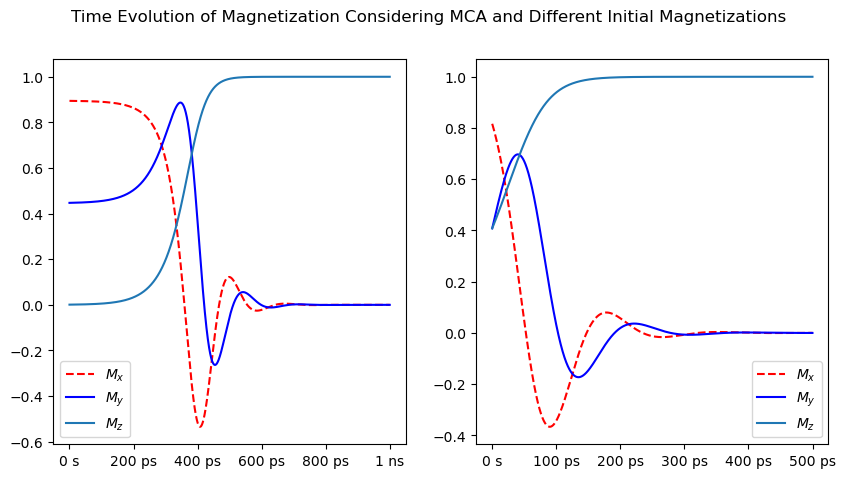

In [6]:
# perpendicular magnetocrystalline anisotropy - equilibrium state in zero applied field
m, t = calculate_magnetization(
    Tn=1e-9,
    m0=np.array([1, 0.5, 0.001]),
    K_u=5e5,
    u_k=np.array([0, 0, 1]),
    H_app=np.zeros(3),
)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(t, m[:, 0], "r--", label=r"$M_x$")
ax[0].plot(t, m[:, 1], "b", label=r"$M_y$")
ax[0].plot(t, m[:, 2], label=r"$M_z$")

ax[0].legend()
ax[0].xaxis.set_major_formatter(timeFormatter)

m, t = calculate_magnetization(
    Tn=5e-10,
    m0=np.array([1, 0.5, 0.5]),
    K_u=5e5,
    u_k=np.array([0, 0, 1]),
    H_app=np.zeros(3),
)

ax[1].plot(t, m[:, 0], "r--", label=r"$M_x$")
ax[1].plot(t, m[:, 1], "b", label=r"$M_y$")
ax[1].plot(t, m[:, 2], label=r"$M_z$")

ax[1].legend()
ax[1].xaxis.set_major_formatter(timeFormatter)

fig.suptitle("Time Evolution of Magnetization Considering MCA and Different Initial Magnetizations")
fig.show()

Varying the timestep, we observe that the solution becomes unstable when going above 50 ps.

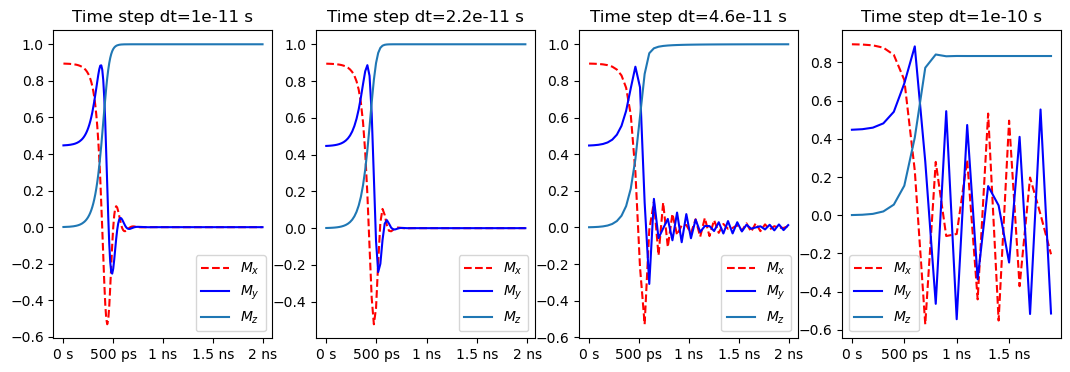

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(13, 4))

for i, dt in enumerate(np.geomspace(1e-11, 1e-10, 4)):
    m, t = calculate_magnetization(
        Tn=2e-9,
        dt=dt,
        m0=np.array([1, 0.5, 0.001]),
        K_u=5e5,
        u_k=np.array([0, 0, 1]),
        H_app=np.zeros(3),
    )

    ax[i].plot(t, m[:, 0], "r--", label=r"$M_x$")
    ax[i].plot(t, m[:, 1], "b", label=r"$M_y$")
    ax[i].plot(t, m[:, 2], label=r"$M_z$")
    ax[i].set_title(f"Time step dt={dt:.2g} s")

    ax[i].legend()
    ax[i].xaxis.set_major_formatter(timeFormatter)


Adding thermal fluctuations to the mix, we observe that the paramagnetic regieme, with the constants we have used, is present for a magnetic sample with $V \leq 0.001 \text{ nm}^3$. This is of course unrealistic, but for this crude example, it could be considered "good enough".

/var/folders/6g/lh1pblvx51zgy2yzn03xbj880000gn/T/ipykernel_76624/3878136635.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


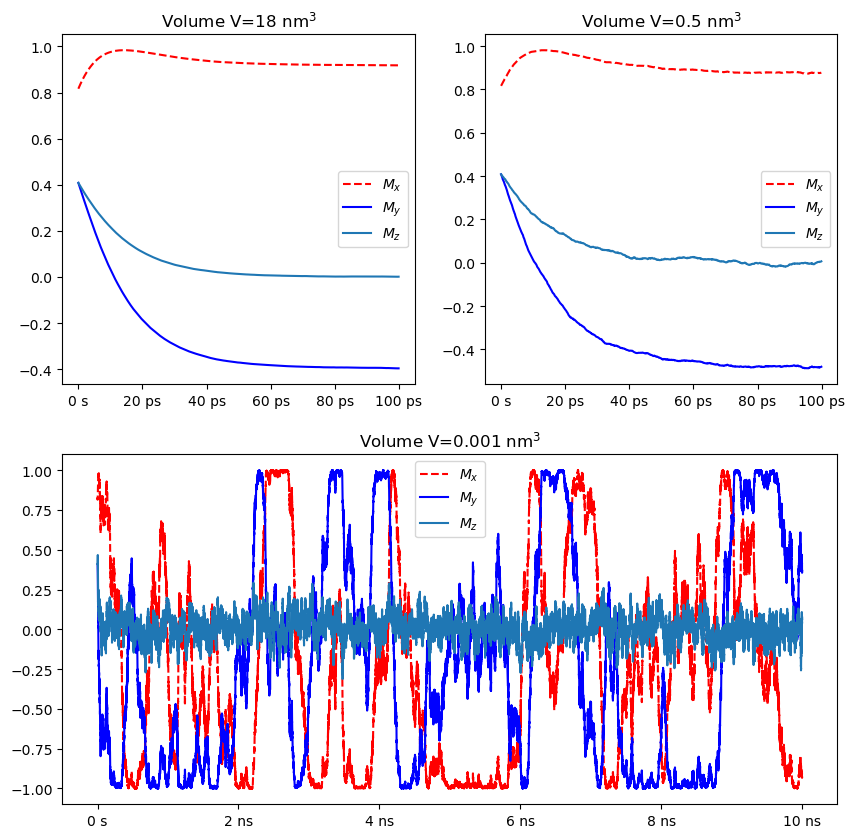

In [8]:
# Thermal field - when do we reach paramagnetic regieme?
m, t = calculate_magnetization(
    Tn=1e-10, m0=np.array([1, 0.5, 0.5]), H_app=np.zeros(3), T=300
)

fig = plt.figure(figsize=(10,10))
gs = GridSpec(2,2, figure=fig)
ax = [
    fig.add_subplot(gs[0,0]),
    fig.add_subplot(gs[0,1]),
    fig.add_subplot(gs[1,:]),
]
ax[0].plot(t, m[:, 0], "r--", label=r"$M_x$")
ax[0].plot(t, m[:, 1], "b", label=r"$M_y$")
ax[0].plot(t, m[:, 2], label=r"$M_z$")

ax[0].legend()
ax[0].xaxis.set_major_formatter(timeFormatter)
ax[0].set_title(r"Volume V=18 nm$^3$")

m, t = calculate_magnetization(
    Tn=1e-10, m0=np.array([1, 0.5, 0.5]), H_app=np.zeros(3), T=300, V=0.1 * 1e-9**3
)

ax[1].plot(t, m[:, 0], "r--", label=r"$M_x$")
ax[1].plot(t, m[:, 1], "b", label=r"$M_y$")
ax[1].plot(t, m[:, 2], label=r"$M_z$")

ax[1].legend()
ax[1].xaxis.set_major_formatter(timeFormatter)
ax[1].set_title(r"Volume V=0.5 nm$^3$")

m, t = calculate_magnetization(
    Tn=1e-8, m0=np.array([1, 0.5, 0.5]), H_app=np.zeros(3), T=300, V=0.001 * 1e-9**3
)

ax[2].plot(t, m[:, 0], "r--", label=r"$M_x$")
ax[2].plot(t, m[:, 1], "b", label=r"$M_y$")
ax[2].plot(t, m[:, 2], label=r"$M_z$")

ax[2].legend()
ax[2].xaxis.set_major_formatter(timeFormatter)
ax[2].set_title(r"Volume V=0.001 nm$^3$")

fig.show()